In [1]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

01:09:40 AM


In [3]:
%%time
df = pd.read_csv('01_db_blastn_July142020_filtered_1e-20_90perc-id_subj.csv')

CPU times: user 3.13 s, sys: 367 ms, total: 3.49 s
Wall time: 3.5 s


In [4]:
df['subject'].nunique()

9583

In [5]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

JAGRRH010000013.1    39657
KM198929.1           13476
NC_011087.1          13038
NC_038215.1          12916
MK695880.1           12846
                     ...  
LN735284.1               1
LN735278.1               1
LN735276.1               1
FJ649304.1               1
X97976.1                 1
Name: subject, Length: 9583, dtype: int64

In [6]:
df.to_csv('01_1_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy.csv')

In [7]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy.csv')

In [8]:
df.head()

,Unnamed: 0,subject
0,JAGRRH010000013.1,39657
1,KM198929.1,13476
2,NC_011087.1,13038
3,NC_038215.1,12916
4,MK695880.1,12846


In [9]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [10]:
df.to_csv('01_1_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy.csv', index= False)

In [11]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy.csv')

In [12]:
df.head()

,subject,count
0,JAGRRH010000013.1,39657
1,KM198929.1,13476
2,NC_011087.1,13038
3,NC_038215.1,12916
4,MK695880.1,12846


## Retrieving (efetch) taxonomy heirarchy from NCBI

In [13]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [14]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [15]:
get_taxon_name ('NC_016703.1')

'Phaeocystis antarctica plastid'

In [16]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [17]:
get_7level_taxonomy ('NC_016703.1')

'Eukaryota; Haptophyceae; Phaeocystales; Phaeocystaceae; Phaeocystis'

In [18]:
df.head()

,subject,count
0,JAGRRH010000013.1,39657
1,KM198929.1,13476
2,NC_011087.1,13038
3,NC_038215.1,12916
4,MK695880.1,12846


In [19]:
df['subject']

0       JAGRRH010000013.1
1              KM198929.1
2             NC_011087.1
3             NC_038215.1
4              MK695880.1
              ...        
9578           LN735284.1
9579           LN735278.1
9580           LN735276.1
9581           FJ649304.1
9582             X97976.1
Name: subject, Length: 9583, dtype: object

In [20]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16.2 µs


In [21]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 5min 55s, sys: 51.9 s, total: 6min 47s
Wall time: 3h 7min 4s


In [22]:
df.to_csv('04_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information

In [23]:
df = pd.read_csv('04_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy_enriched.csv')

In [24]:
df['7Level_Taxonomy'].nunique()

3195

In [25]:
df.head(5)

,subject,count,7Level_Taxonomy
0,JAGRRH010000013.1,39657,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
1,KM198929.1,13476,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...
2,NC_011087.1,13038,Eukaryota; Sar; Rhizaria; Imbricatea; Silicofi...
3,NC_038215.1,12916,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...
4,MK695880.1,12846,Eukaryota; Rhodophyta; Bangiophyceae; Bangiale...


In [26]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [27]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [28]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 1.33 s, sys: 7.71 ms, total: 1.33 s
Wall time: 1.33 s


In [29]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,JAGRRH010000013.1,39657,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
1,KM198929.1,13476,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4
2,NC_011087.1,13038,Eukaryota; Sar; Rhizaria; Imbricatea; Silicofi...,8
3,NC_038215.1,12916,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4
4,MK695880.1,12846,Eukaryota; Rhodophyta; Bangiophyceae; Bangiale...,6


In [30]:
df['7Level_Lenght'].value_counts()

1     2476
2     1675
6     1600
9      905
4      664
8      652
7      515
10     373
5      293
3      243
11     187
Name: 7Level_Lenght, dtype: int64

In [31]:
df.shape

(9583, 4)

In [32]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [33]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,JAGRRH010000013.1,39657,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
1,KM198929.1,13476,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4,4_Levels
2,NC_011087.1,13038,Eukaryota; Sar; Rhizaria; Imbricatea; Silicofi...,8,8_Levels
3,NC_038215.1,12916,Eukaryota; Glaucocystophyceae; Cyanophoraceae;...,4,4_Levels
4,MK695880.1,12846,Eukaryota; Rhodophyta; Bangiophyceae; Bangiale...,6,6_Levels


<AxesSubplot:>

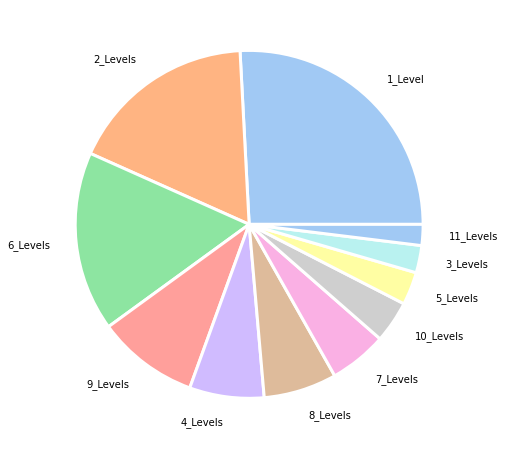

In [34]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

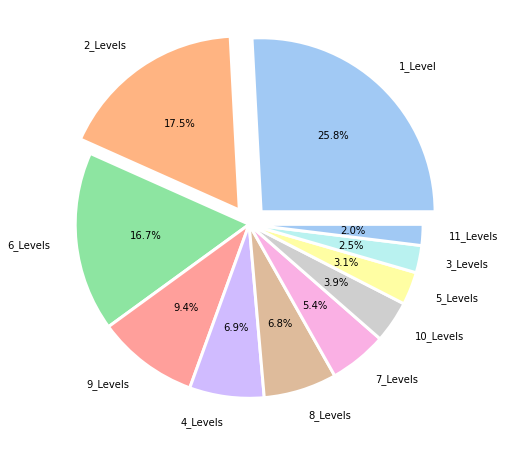

In [35]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                     explode = explode)

<AxesSubplot:>

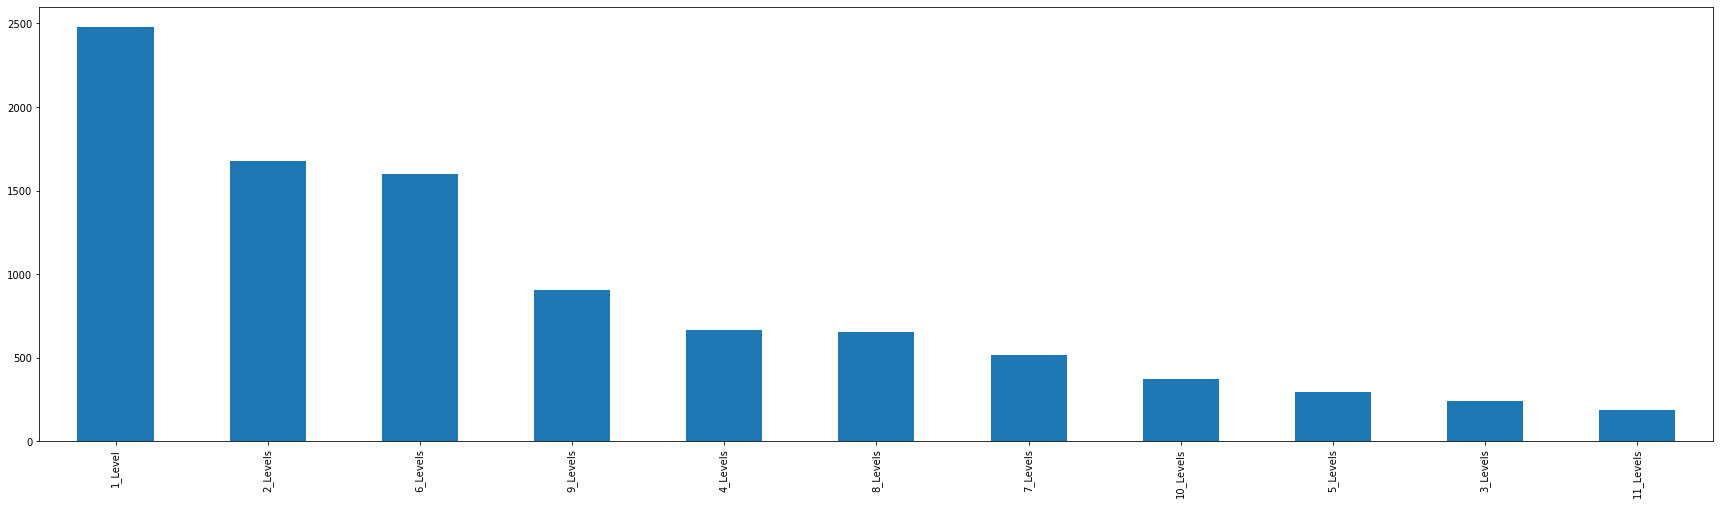

In [36]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)

In [37]:
df.to_csv('05_July142020_filtered_1e-20_90perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)